# Logistic Regression

redo model training with new data in this script

In [27]:
import pandas as pd
import rdata
from sklearn.linear_model import LogisticRegression
import json
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from functions import get_cv_score
from sklearn.metrics import accuracy_score

In [28]:
df = pd.read_pickle("../data/df_uni_bi_tri_normalized.pickle")
df =df.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

Add language that is going to be the label/ target for model:

In [29]:
# read df with language:
path_ind_diff = r"../data/version 1.1/primary data/individual differences data/joint.ind.diff.l2.rda"
parsed_readrate = rdata.parser.parse_file(path_ind_diff)
converted_readrate = rdata.conversion.convert(parsed_readrate)
df_readrate = converted_readrate['joint_id'][['uniform_id', 'lang']]

# need multiindex to merge properly:
df_readrate.columns = pd.MultiIndex.from_product([['labels'], df_readrate.columns]) 

# join language
df_main = df.merge(df_readrate, left_on = [('id', 'uniform_id')], right_on= [('labels', 'uniform_id')])
df_main = df_main.drop([('labels', 'uniform_id')], axis=1)

# encode language as lables ( using old lookup json):
with open("../data/outputs/language_lookup.json") as json_file:
    language_lookup = json.load(json_file)

df_main[('labels', 'lang_code')] = df_main[('labels', 'lang')].replace(language_lookup).values

In [30]:
df_main[('labels', 'lang')].value_counts()

ee    23
fi    23
ge    23
en    21
sp    21
it    20
he    18
Name: (labels, lang), dtype: int64

In [31]:
23/149

0.15436241610738255

In [5]:
import itertools
from tqdm import tqdm

In [6]:
##### only for 4 lang check: #####

#df_main = df_main[df_main[('labels', 'lang')].isin(['ee', 'fi', 'it', 'sp'])]

dict_performances = {}
dict_performances_groups = []

for i in tqdm(range(2, 8)): # 8
    comb = list(itertools.combinations(['ee', 'fi', 'ge', 'he', 'it', 'en', 'sp'], i))
    print(comb)
    temp = []
    for c in comb:
        #print(c)
        df_main_ = df_main[df_main[('labels', 'lang')].isin(c)]
        logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)
        columns = ['TF_uni', 'FP_uni', 'FF_uni', 'TF_bi', 'FP_bi', 'FF_bi', 'TF_tri', 'FP_tri', 'FF_tri' ]
        cross_val_scores = get_cv_score(df_main_, columns, logreg)
        dict_performances[str(c)] = np.mean(cross_val_scores)
        temp.append(np.mean(cross_val_scores))
    dict_performances_groups.append([i, np.mean(temp)])
##########

  0%|          | 0/6 [00:00<?, ?it/s]

[('ee', 'fi'), ('ee', 'ge'), ('ee', 'he'), ('ee', 'it'), ('ee', 'en'), ('ee', 'sp'), ('fi', 'ge'), ('fi', 'he'), ('fi', 'it'), ('fi', 'en'), ('fi', 'sp'), ('ge', 'he'), ('ge', 'it'), ('ge', 'en'), ('ge', 'sp'), ('he', 'it'), ('he', 'en'), ('he', 'sp'), ('it', 'en'), ('it', 'sp'), ('en', 'sp')]


5it [00:04,  1.23it/s]


0.9894736842105264


5it [00:04,  1.12it/s]


0.9894736842105264


5it [00:03,  1.60it/s]


1.0


5it [00:04,  1.17it/s]


1.0


5it [00:04,  1.10it/s]


1.0


5it [00:03,  1.63it/s]


1.0


5it [00:02,  2.42it/s]


0.8947368421052632


5it [00:02,  1.98it/s]


0.8470588235294118


5it [00:01,  2.54it/s]


0.8


5it [00:01,  2.52it/s]


1.0


5it [00:02,  2.38it/s]


0.7222222222222222


5it [00:02,  2.24it/s]


0.8823529411764707


5it [00:02,  2.26it/s]


0.9666666666666666


5it [00:01,  2.83it/s]


1.0


5it [00:02,  2.44it/s]


0.9222222222222222


5it [00:02,  1.96it/s]


0.875


5it [00:02,  2.06it/s]


1.0


5it [00:01,  3.11it/s]


0.7625


5it [00:02,  2.39it/s]


1.0


5it [00:01,  3.49it/s]


0.7058823529411764


5it [00:01,  2.90it/s]
 17%|█▋        | 1/6 [00:54<04:34, 54.86s/it]

1.0
[('ee', 'fi', 'ge'), ('ee', 'fi', 'he'), ('ee', 'fi', 'it'), ('ee', 'fi', 'en'), ('ee', 'fi', 'sp'), ('ee', 'ge', 'he'), ('ee', 'ge', 'it'), ('ee', 'ge', 'en'), ('ee', 'ge', 'sp'), ('ee', 'he', 'it'), ('ee', 'he', 'en'), ('ee', 'he', 'sp'), ('ee', 'it', 'en'), ('ee', 'it', 'sp'), ('ee', 'en', 'sp'), ('fi', 'ge', 'he'), ('fi', 'ge', 'it'), ('fi', 'ge', 'en'), ('fi', 'ge', 'sp'), ('fi', 'he', 'it'), ('fi', 'he', 'en'), ('fi', 'he', 'sp'), ('fi', 'it', 'en'), ('fi', 'it', 'sp'), ('fi', 'en', 'sp'), ('ge', 'he', 'it'), ('ge', 'he', 'en'), ('ge', 'he', 'sp'), ('ge', 'it', 'en'), ('ge', 'it', 'sp'), ('ge', 'en', 'sp'), ('he', 'it', 'en'), ('he', 'it', 'sp'), ('he', 'en', 'sp'), ('it', 'en', 'sp')]


5it [00:03,  1.56it/s]


0.8857142857142858


5it [00:02,  1.86it/s]


0.8692307692307691


5it [00:01,  4.20it/s]


0.8518518518518517


5it [00:01,  4.39it/s]


1.0


5it [00:01,  4.19it/s]


0.6962962962962964


5it [00:01,  4.28it/s]


0.9307692307692308


5it [00:01,  4.77it/s]


0.9407407407407407


5it [00:00,  5.15it/s]


0.9851851851851852


5it [00:00,  5.62it/s]


0.8962962962962964


5it [00:00,  5.04it/s]


0.9119999999999999


5it [00:01,  3.33it/s]


0.992


5it [00:01,  3.08it/s]


0.8480000000000001


5it [00:01,  3.53it/s]


1.0


5it [00:01,  3.06it/s]


0.8307692307692308


5it [00:01,  3.31it/s]


0.9923076923076923


5it [00:01,  3.09it/s]


0.7692307692307694


5it [00:01,  3.35it/s]


0.7555555555555555


5it [00:01,  4.23it/s]


0.9407407407407409


5it [00:01,  4.19it/s]


0.6296296296296297


5it [00:01,  2.87it/s]


0.656


5it [00:01,  2.99it/s]


0.8480000000000001


5it [00:01,  2.96it/s]


0.504


5it [00:01,  4.24it/s]


0.8384615384615384


5it [00:01,  3.60it/s]


0.4615384615384615


5it [00:01,  3.28it/s]


0.6692307692307692


5it [00:01,  4.34it/s]


0.8320000000000001


5it [00:00,  5.12it/s]


0.9199999999999999


5it [00:01,  4.20it/s]


0.784


5it [00:01,  3.17it/s]


0.9615384615384617


5it [00:01,  3.14it/s]


0.7692307692307693


5it [00:01,  3.69it/s]


0.9153846153846155


5it [00:01,  3.08it/s]


0.9083333333333332


5it [00:01,  3.06it/s]


0.625


5it [00:01,  3.11it/s]


0.875


5it [00:01,  3.02it/s]
 33%|███▎      | 2/6 [01:46<03:32, 53.23s/it]

0.792
[('ee', 'fi', 'ge', 'he'), ('ee', 'fi', 'ge', 'it'), ('ee', 'fi', 'ge', 'en'), ('ee', 'fi', 'ge', 'sp'), ('ee', 'fi', 'he', 'it'), ('ee', 'fi', 'he', 'en'), ('ee', 'fi', 'he', 'sp'), ('ee', 'fi', 'it', 'en'), ('ee', 'fi', 'it', 'sp'), ('ee', 'fi', 'en', 'sp'), ('ee', 'ge', 'he', 'it'), ('ee', 'ge', 'he', 'en'), ('ee', 'ge', 'he', 'sp'), ('ee', 'ge', 'it', 'en'), ('ee', 'ge', 'it', 'sp'), ('ee', 'ge', 'en', 'sp'), ('ee', 'he', 'it', 'en'), ('ee', 'he', 'it', 'sp'), ('ee', 'he', 'en', 'sp'), ('ee', 'it', 'en', 'sp'), ('fi', 'ge', 'he', 'it'), ('fi', 'ge', 'he', 'en'), ('fi', 'ge', 'he', 'sp'), ('fi', 'ge', 'it', 'en'), ('fi', 'ge', 'it', 'sp'), ('fi', 'ge', 'en', 'sp'), ('fi', 'he', 'it', 'en'), ('fi', 'he', 'it', 'sp'), ('fi', 'he', 'en', 'sp'), ('fi', 'it', 'en', 'sp'), ('ge', 'he', 'it', 'en'), ('ge', 'he', 'it', 'sp'), ('ge', 'he', 'en', 'sp'), ('ge', 'it', 'en', 'sp'), ('he', 'it', 'en', 'sp')]


5it [00:01,  2.75it/s]


0.8228571428571427


5it [00:01,  2.82it/s]


0.8222222222222222


5it [00:01,  4.30it/s]


0.9555555555555555


5it [00:01,  3.77it/s]


0.6555555555555556


5it [00:01,  3.60it/s]


0.7529411764705883


5it [00:01,  3.43it/s]


0.8941176470588234


5it [00:01,  3.27it/s]


0.6705882352941177


5it [00:01,  2.64it/s]


0.8628571428571428


5it [00:01,  2.70it/s]


0.6285714285714284


5it [00:01,  2.74it/s]


0.788888888888889


5it [00:01,  2.82it/s]


0.8941176470588234


5it [00:01,  2.56it/s]


0.9529411764705882


5it [00:02,  2.49it/s]


0.8411764705882353


5it [00:01,  2.59it/s]


0.937142857142857


5it [00:01,  3.13it/s]


0.7885714285714286


5it [00:01,  3.98it/s]


0.9333333333333332


5it [00:01,  3.47it/s]


0.9272727272727274


5it [00:01,  3.22it/s]


0.7636363636363637


5it [00:01,  3.16it/s]


0.8882352941176471


5it [00:01,  3.44it/s]


0.8352941176470589


5it [00:01,  2.65it/s]


0.7117647058823529


5it [00:01,  3.13it/s]


0.8529411764705882


5it [00:01,  2.56it/s]


0.5941176470588235


5it [00:01,  3.39it/s]


0.7885714285714286


5it [00:01,  3.47it/s]


0.5828571428571429


5it [00:01,  3.82it/s]


0.6944444444444444


5it [00:01,  3.84it/s]


0.7818181818181819


5it [00:01,  4.15it/s]


0.4909090909090909


5it [00:01,  4.36it/s]


0.6529411764705882


5it [00:01,  3.88it/s]


0.5764705882352942


5it [00:01,  3.91it/s]


0.884848484848485


5it [00:01,  4.53it/s]


0.7272727272727273


5it [00:01,  4.42it/s]


0.8411764705882353


5it [00:01,  4.93it/s]


0.7647058823529411


5it [00:01,  3.83it/s]
 50%|█████     | 3/6 [02:40<02:40, 53.57s/it]

0.75625
[('ee', 'fi', 'ge', 'he', 'it'), ('ee', 'fi', 'ge', 'he', 'en'), ('ee', 'fi', 'ge', 'he', 'sp'), ('ee', 'fi', 'ge', 'it', 'en'), ('ee', 'fi', 'ge', 'it', 'sp'), ('ee', 'fi', 'ge', 'en', 'sp'), ('ee', 'fi', 'he', 'it', 'en'), ('ee', 'fi', 'he', 'it', 'sp'), ('ee', 'fi', 'he', 'en', 'sp'), ('ee', 'fi', 'it', 'en', 'sp'), ('ee', 'ge', 'he', 'it', 'en'), ('ee', 'ge', 'he', 'it', 'sp'), ('ee', 'ge', 'he', 'en', 'sp'), ('ee', 'ge', 'it', 'en', 'sp'), ('ee', 'he', 'it', 'en', 'sp'), ('fi', 'ge', 'he', 'it', 'en'), ('fi', 'ge', 'he', 'it', 'sp'), ('fi', 'ge', 'he', 'en', 'sp'), ('fi', 'ge', 'it', 'en', 'sp'), ('fi', 'he', 'it', 'en', 'sp'), ('ge', 'he', 'it', 'en', 'sp')]


5it [00:01,  3.34it/s]


0.7441860465116279


5it [00:01,  3.85it/s]


0.8363636363636363


5it [00:01,  2.53it/s]


0.6772727272727271


5it [00:02,  2.42it/s]


0.8454545454545455


5it [00:02,  2.29it/s]


0.65


5it [00:01,  2.93it/s]


0.8044444444444444


5it [00:02,  2.34it/s]


0.8095238095238095


5it [00:01,  3.18it/s]


0.5952380952380951


5it [00:01,  3.36it/s]


0.7395348837209302


5it [00:01,  3.97it/s]


0.6863636363636363


5it [00:01,  3.98it/s]


0.8904761904761903


5it [00:01,  4.05it/s]


0.7333333333333333


5it [00:01,  2.78it/s]


0.8883720930232558


5it [00:01,  2.93it/s]


0.8272727272727272


5it [00:01,  4.06it/s]


0.7333333333333333


5it [00:01,  3.52it/s]


0.7904761904761906


5it [00:01,  3.42it/s]


0.5571428571428572


5it [00:02,  2.38it/s]


0.7255813953488373


5it [00:02,  2.39it/s]


0.6954545454545454


5it [00:01,  2.65it/s]


0.5952380952380952


5it [00:02,  2.18it/s]
 67%|██████▋   | 4/6 [03:17<01:33, 46.73s/it]

0.7238095238095239
[('ee', 'fi', 'ge', 'he', 'it', 'en'), ('ee', 'fi', 'ge', 'he', 'it', 'sp'), ('ee', 'fi', 'ge', 'he', 'en', 'sp'), ('ee', 'fi', 'ge', 'it', 'en', 'sp'), ('ee', 'fi', 'he', 'it', 'en', 'sp'), ('ee', 'ge', 'he', 'it', 'en', 'sp'), ('fi', 'ge', 'he', 'it', 'en', 'sp')]


5it [00:02,  2.23it/s]


0.826923076923077


5it [00:01,  2.53it/s]


0.6461538461538461


5it [00:02,  2.00it/s]


0.7038461538461538


5it [00:02,  2.38it/s]


0.7471698113207547


5it [00:03,  1.66it/s]


0.6705882352941177


5it [00:02,  2.17it/s]


0.7568627450980393


5it [00:02,  1.71it/s]
 83%|████████▎ | 5/6 [03:34<00:36, 36.10s/it]

0.6392156862745098
[('ee', 'fi', 'ge', 'he', 'it', 'en', 'sp')]


5it [00:02,  1.93it/s]
100%|██████████| 6/6 [03:37<00:00, 36.17s/it]

0.6599999999999999


In [7]:
dict_performances

{"('ee', 'fi')": 0.9894736842105264,
 "('ee', 'ge')": 0.9894736842105264,
 "('ee', 'he')": 1.0,
 "('ee', 'it')": 1.0,
 "('ee', 'en')": 1.0,
 "('ee', 'sp')": 1.0,
 "('fi', 'ge')": 0.8947368421052632,
 "('fi', 'he')": 0.8470588235294118,
 "('fi', 'it')": 0.8,
 "('fi', 'en')": 1.0,
 "('fi', 'sp')": 0.7222222222222222,
 "('ge', 'he')": 0.8823529411764707,
 "('ge', 'it')": 0.9666666666666666,
 "('ge', 'en')": 1.0,
 "('ge', 'sp')": 0.9222222222222222,
 "('he', 'it')": 0.875,
 "('he', 'en')": 1.0,
 "('he', 'sp')": 0.7625,
 "('it', 'en')": 1.0,
 "('it', 'sp')": 0.7058823529411764,
 "('en', 'sp')": 1.0,
 "('ee', 'fi', 'ge')": 0.8857142857142858,
 "('ee', 'fi', 'he')": 0.8692307692307691,
 "('ee', 'fi', 'it')": 0.8518518518518517,
 "('ee', 'fi', 'en')": 1.0,
 "('ee', 'fi', 'sp')": 0.6962962962962964,
 "('ee', 'ge', 'he')": 0.9307692307692308,
 "('ee', 'ge', 'it')": 0.9407407407407407,
 "('ee', 'ge', 'en')": 0.9851851851851852,
 "('ee', 'ge', 'sp')": 0.8962962962962964,
 "('ee', 'he', 'it')": 0.9

In [8]:
dict_performances_groups

[[2, 0.9217899732992612],
 [3, 0.8310296063724636],
 [4, 0.7804847302557387],
 [5, 0.7404224814191591],
 [6, 0.7129656507014998],
 [7, 0.6599999999999999]]

In [9]:
import matplotlib.pyplot as plt

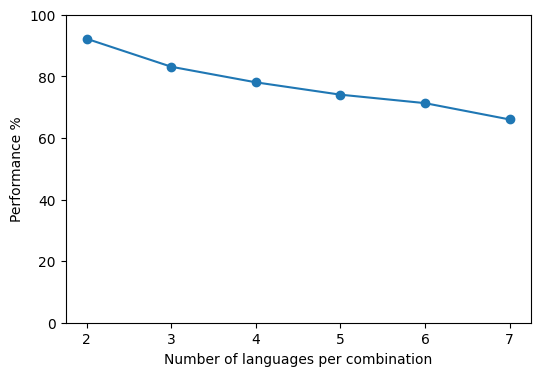

In [12]:

fig, axes = plt.subplots(ncols=1, figsize=(6,4))
axes.plot(np.array(dict_performances_groups)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups)[:, 1]], marker='o')
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);

## LogReg NLIR

In [13]:
# defining model with correct solver
logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0)

In [14]:
# columns used in training
columns = ['TF_uni', 'FP_uni', 'FF_uni', 'TF_bi', 'FP_bi', 'FF_bi', 'TF_tri', 'FP_tri', 'FF_tri' ]

Cross validation score: 

(only needed for report and not for further coding)

In [15]:
cross_val_scores = get_cv_score(df_main, columns, logreg)
print(np.mean(cross_val_scores))
#cross_val_scores # [0.65, 0.5666666666666667, 0.6, 0.5166666666666667, 0.5666666666666667]

5it [00:08,  1.79s/it]

0.6599999999999999
0.6599999999999999


In [16]:
# real train-test split to be used for further analysis: 
train_subset = df_main[columns]
train_label_subset = df_main[('labels', 'lang_code')]

gss = GroupShuffleSplit(n_splits=5, test_size = 0.3, random_state=42)
split_indexes = list(gss.split(train_subset, train_label_subset, df_main[('id','uniform_id')]))[0]
train_idx = list(split_indexes[0])
test_idx = list(split_indexes[1])

X_train = train_subset.iloc[train_idx]
y_train = train_label_subset.iloc[train_idx]
X_test = train_subset.iloc[test_idx]
y_test = train_label_subset.iloc[test_idx]

test_lang = df_main[('labels', 'lang')].iloc[test_idx]
test_lang_codes = df_main[('labels', 'lang_code')].iloc[test_idx]

In [17]:
# fit model:
logreg.fit(X_train, y_train)

# only for score count:
y_pred = logreg.predict(X_test)
test_acc_score = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {test_acc_score}; overall cross validation accuracy {np.mean(cross_val_scores)}')
# Test set accuracy: 0.6888888888888889; overall cross validation accuracy 0.5800000000000001 for all languages
# Test set accuracy: 0.4074074074074074; overall cross validation accuracy 0.4914285714285714 for 4 languages


Test set accuracy: 0.7777777777777778; overall cross validation accuracy 0.6599999999999999


Test set accuracy: 0.7857142857142857; overall cross validation accuracy 0.6736842105263158 for ee - fi (46)

Test set accuracy: 0.8571428571428571; overall cross validation accuracy 0.711111111111111 for ee - sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.8 for ee -it  (43)

Test set accuracy: 0.5384615384615384; overall cross validation accuracy 0.8222222222222222 fi it (43)

Test set accuracy: 0.5714285714285714; overall cross validation accuracy 0.6555555555555556 fi sp (44)

Test set accuracy: 0.7692307692307693; overall cross validation accuracy 0.6823529411764706 it sp (41)



Test set accuracy: 0.5238095238095238; overall cross validation accuracy 0.5407407407407407 ee fi sp 

Test set accuracy: 0.55; overall cross validation accuracy 0.6814814814814815 ee fi it

Test set accuracy: 0.55; overall cross validation accuracy 0.6923076923076923 ee sp it

Test set accuracy: 0.5; overall cross validation accuracy 0.6538461538461539 fi sp it



















### LogReg Similarity

Create dictionary with df for each language separately to be used for similarity metrics:

In [18]:
X_test['lang'] = test_lang # add language column
languages = list(test_lang.unique())
dict_lang = {}
for ll in languages:
    df = X_test[X_test['lang'] == ll]
    dict_lang[ll] = df


dict_proba ={}
len_dfs = []
lang_identifier = []
for key in dict_lang.keys():
    lang_df = dict_lang[key][columns]
    test_proba = logreg.predict_proba(lang_df) # predicting probabilities here
    len_df = len(lang_df)
    test_proba = test_proba.sum(axis=0)   # sum bc they are normalised by number of participants
    dict_proba[key] = test_proba
    len_dfs.append(len_df) # record length of language df
    lang_identifier.append(key)

/tmp/ipykernel_3513/2390796384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lang'] = test_lang # add language column


In [19]:
# to pandas:
df_predictions = pd.DataFrame(dict_proba).reset_index()
# cols are lang on which predicted and rows are outputs

# add col with lenghts and lang name
df_predictions['length'] = len_dfs
df_predictions['lang'] = lang_identifier

In [20]:
df_predictions

,index,ee,fi,ge,he,it,en,sp,length,lang
0,0,9.846246e+00,6.157969e-04,2.507169e-05,8.313483e-06,2.015033e-05,1.469545e-07,6.666040e-03,10,ee
1,1,8.926568e-11,7.916918e-10,1.329820e-12,1.536341e-11,2.232581e-08,7.999684e+00,3.792708e-07,6,fi
2,2,1.493617e-01,2.745390e+00,2.250879e-02,3.129863e-01,3.170024e-01,3.137036e-04,2.277848e+00,8,ge
3,3,4.444751e-04,1.667750e+00,7.661695e+00,8.474113e-04,1.415717e-01,1.748333e-06,4.181654e-02,2,he
4,4,1.497419e-04,3.146220e-01,1.387545e-01,9.979664e-01,2.449953e-02,4.458954e-09,3.366872e-02,6,it
5,5,3.414054e-03,7.894457e-01,8.266450e-02,6.661426e-01,3.736269e+00,5.597879e-08,1.688869e+00,8,en
6,6,3.842800e-04,4.821766e-01,9.435238e-02,2.204896e-02,1.780637e+00,1.847541e-08,9.511312e-01,5,sp


Convert into pair dictionary:

In [21]:
lang_values = []
lang_pairs = []
#lang_similarities = {}
for key1 in df_predictions['lang'].unique(): 
    for key2 in df_predictions['lang'].unique(): 
        val1 = float(df_predictions[df_predictions['lang'] == key1][key2])
        val2 = float(df_predictions[df_predictions['lang'] == key2][key1])
        len1 = float(df_predictions[df_predictions['lang'] == key1]['length'])
        len2 = float(df_predictions[df_predictions['lang'] == key2]['length'])
        
        #lang_similarities[f'{key1}_{key2}'] = ((val1 + val2) /(len1+len2)) #  divide by corpus length bc summed above
        lang_values.append((val1 + val2) / (len1+len2))
        lang_pairs.append(f'{key1}_{key2}')

In [22]:
df_lang_similarities = pd.DataFrame({'pair': lang_pairs, 'logreg_val': lang_values})

In [23]:
# inverted 
df_lang_similarities['logreg_val_inverted'] = 1 - df_lang_similarities['logreg_val']

In [24]:
#lang_similarities # invert as 1- proba. 
df_lang_similarities

,pair,logreg_val,logreg_val_inverted
0,ee_ee,9.846246e-01,0.015375
1,ee_fi,3.848731e-05,0.999962
2,ee_ge,8.299264e-03,0.991701
3,ee_he,3.773238e-05,0.999962
4,ee_it,1.061826e-05,0.999989
5,ee_en,1.896778e-04,0.999810
6,ee_sp,4.700214e-04,0.999530
7,fi_ee,3.848731e-05,0.999962
8,fi_fi,1.319486e-10,1.000000
9,fi_ge,1.960993e-01,0.803901


In [26]:
# write 

df_lang_similarities.to_csv("../data/outputs/logreg_similarity_new.csv", index = False) # rename for other saves

**ToDos:**

- investigate why 4 lang perform worse than all. maybe try with 2? ( very different and very similar - eg ee vs fi and ee and sp)
- do separate runs with only bi and bi+tri-grams and fill table in report
- plot language tree using both similarity metrics
- do majority class baseline (cv accuracy only)

